In [1]:
%matplotlib inline

In [189]:
import numpy as np

''' initialize_nodes '''
def sample_data_point(data, n=1):
    return data[np.random.choice(len(data), n), :]

''' format_input_data '''
def asfloat(value):
    float_type = 'float32'
    if isinstance(value, (np.matrix, np.ndarray)):
        return value.astype(float_type) if value.dtype != np.dtype(float_type) else value
    float_x_type = np.cast[float_type]
    return float_x_type(value)

def format_data(data, is_feature1d=True, copy=False, make_float=True):
    if data is None:
        return data
    data = asfloat(data) if make_float else data
    if not isinstance(data, np.ndarray) or copy:
        data = np.array(data, copy=copy)
    n_features = data.shape[-1]
    if data.ndim == 1:
        data_shape = (n_features, 1) if is_feature1d else (1, n_features)
        data = data.reshape(data_shape)
    return data

''' train '''
def ceil(a, b):
    return b and (a//b + bool(a%b))

def count_samples(inputs):
    return count_samples(inputs[0]) if isinstance(inputs, (list, tuple)) else len(inputs)

def apply_slices(inputs, indices):
    if inputs is None:
        return inputs
    if isinstance(inputs, (list, tuple)):
        return [apply_slices(input_, indices) for input_ in inputs]
    return inputs[indices]

def minibatches(inputs, batch_size=None, shuffle=False):
    n_samples = count_samples(inputs)
    batch_size = n_samples if batch_size is None else batch_size
    n_batches = int(ceil(n_samples, batch_size))
    if shuffle:
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        for index in range(n_batches):
            yield apply_slices(inputs, indices[slice(index * batch_size, (index + 1) * batch_size)])
    elif n_batches != 1:
        for index in range(n_batches):
            yield apply_slices(inputs, slice(index * batch_size, (index + 1) * batch_size))
    else:
        yield inputs

''' one_training_update '''
def resolve_attr(obj, attr):
    for name in attr.split('.'):
        obj = getattr(obj, name)
    return obj

def attrgetter(*items):
    if any(not isinstance(item, str) for item in items):
        raise TypeError('Attribute name must be a string')
    if len(items) == 1:
        def g(obj):
            return resolve_attr(obj, items[0])
    else:
        def g(obj):
            return tuple(resolve_attr(obj, attr) for attr in items)
    return g

''' neuron_node '''
class NeuronNode(object):
    def __init__(self, weight):
        self.error = 0
        self.weight = weight

''' neural_gas_graph '''
class NeuralGasGraph(object):
    def __init__(self):
        self.edges = {}
        self.edges_per_node = {}

    @property
    def n_edges(self):
        return len(self.edges)

    @property
    def n_nodes(self):
        return len(self.edges_per_node)

    @property
    def nodes(self):
        return list(self.edges_per_node.keys())

    def add_node(self, node):
        self.edges_per_node[node] = set()

    def remove_node(self, node):
        if self.edges_per_node[node]:
            raise ValueError('Cannot remove node, because it is connected to {} other node(s)'
                             .format(len(self.edges_per_node[node])))
        del self.edges_per_node[node]

    def find_edge_id(self, node_1, node_2):
        if (node_1, node_2) in self.edges:
            return (node_1, node_2)
        if (node_2, node_1) in self.edges:
            return (node_2, node_1)
        raise ValueError('Edge between specified nodes does not exist')

    def reset_edge(self, node_1, node_2):
        self.edges[self.find_edge_id(node_1, node_2)] = 0

    def add_edge(self, node_1, node_2):
        if node_2 in self.edges_per_node[node_1]:
            return self.reset_edge(node_1, node_2)
        self.edges_per_node[node_1].add(node_2)
        self.edges_per_node[node_2].add(node_1)
        self.edges[(node_1, node_2)] = 0

    def remove_edge(self, node_1, node_2):
        edge_id = self.find_edge_id(node_1, node_2)
        self.edges_per_node[node_1].remove(node_2)
        self.edges_per_node[node_2].remove(node_1)
        del self.edges[edge_id]

''' base_network '''
class BaseNetwork():
    def __init__(self):
        super(BaseNetwork, self).__init__()
        self.n_updates_made = 0
        self.last_epoch = 0

    def score(self, X, y):
        raise NotImplementedError()

    def train(self, X_train, y_train=None, X_test=None, y_test=None, epochs=100, batch_size=None):
        if epochs <= 0:
            raise ValueError('Number of epochs needs to be a positive number')
        epochs = int(epochs)
        first_epoch = self.last_epoch + 1
        batch_size = batch_size or getattr(self, 'batch_size', None)
        # step 1. iterate through the data
        for epoch in range(first_epoch, first_epoch + epochs):
            self.last_epoch = epoch
            iterator = minibatches((X_train, y_train), batch_size, self.shuffle_data)
            for X_batch, y_batch in iterator:
                train_error = self.one_training_update(X_batch, y_batch)
                self.n_updates_made += 1
            if X_test is not None:
                validation_error = self.score(X_test, y_test)

    def one_training_update(self, X_train, y_train=None):
        raise NotImplementedError()

''' growing_neural_gas '''
class GrowingNeuralGas(BaseNetwork):
    def __init__(
        self,
        n_inputs=1,
        n_start_nodes=2,
        shuffle_data=False,
        verbose=False,
        step=0.2,
        neighbor_step=0.05,
        max_edge_age=100,
        max_nodes=1000,
        n_iter_before_neuron_added=1000,
        after_split_error_decay_rate=0.5,
        error_decay_rate=0.995,
        min_distance_for_update=0.0
    ):
        super(GrowingNeuralGas, self).__init__()
        self.n_inputs = n_inputs
        self.n_start_nodes = n_start_nodes
        self.shuffle_data = shuffle_data
        self.verbose = verbose
        self.step = step
        self.neighbor_step = neighbor_step
        self.max_edge_age = max_edge_age
        self.max_nodes = max_nodes
        self.n_iter_before_neuron_added = n_iter_before_neuron_added
        self.after_split_error_decay_rate = after_split_error_decay_rate
        self.error_decay_rate = error_decay_rate
        self.min_distance_for_update = min_distance_for_update
        self.n_updates = 0
        self.graph = NeuralGasGraph()

    def format_input_data(self, X):
        X = format_data(X, self.n_inputs == 1)
        if X.ndim != 2:
            raise ValueError('Cannot make prediction, because input data has more than two dimensions')
        n_samples, n_features = X.shape
        if n_features != self.n_inputs:
            raise ValueError('Input data expected to have {} features, but got {}'.format(self.n_inputs, n_features))
        return X

    def initialize_nodes(self, data):
        # step 0. start with two units a and b at random positions w_a and w_b
        self.graph = NeuralGasGraph()
        for sample in sample_data_point(data, n=self.n_start_nodes):
            self.graph.add_node(NeuronNode(sample.reshape(1, -1)))

    def train(self, X_train, epochs=100):
        X_train = self.format_input_data(X_train)
        if not self.graph.nodes:
            self.initialize_nodes(X_train)
        return super(GrowingNeuralGas, self).train(X_train=X_train, y_train=None, X_test=None, y_test=None, epochs=epochs)

    def find_nearest_unit(self, graph, sample):
        # step 2. find the nearest unit s_1 and the second-nearest unit s_2
        nodes = graph.nodes
        weights = np.concatenate([node.weight for node in nodes])
        distance = np.linalg.norm(weights - sample, axis=1)
        neuron_ids = np.argsort(distance)
        closest_neuron = nodes[neuron_ids[0]]
        second_closest = nodes[neuron_ids[1]]
        return distance, neuron_ids[0], closest_neuron, second_closest

    def update_edges(self, graph, closest_neuron, max_edge_age, neighbor_step, sample):
        for to_neuron in list(graph.edges_per_node[closest_neuron]):
            edge_id = graph.find_edge_id(to_neuron, closest_neuron)
            age = graph.edges[edge_id]
            # step 7. remove edges with an age larger than a_max
            if age >= max_edge_age:
                graph.remove_edge(to_neuron, closest_neuron)
                # step 7. if this results in points having no emanating edges, remove them as well
                if not graph.edges_per_node[to_neuron]:
                    graph.remove_node(to_neuron)
            else:
                # step 3. increment the age of all edges emanating from s_1
                graph.edges[edge_id] += 1
                # step 5. move the direct topological neighbors of s_1 toward the input signal by the fraction e_n
                to_neuron.weight += neighbor_step * (sample - to_neuron.weight)
        return graph

    def insert_new_unit(self, graph, after_split_error_decay_rate):
        # step 8a. determine the unit q with the maximum accumulated error
        largest_error_neuron = max(graph.nodes, key=attrgetter('error'))
        # step 8b. determine the unit f with the maximum accumulated error
        neighbor_neuron = max(graph.edges_per_node[largest_error_neuron], key=attrgetter('error'))
        # step 8d. decrease the error variables of q and f by multiplying them with a constant a
        largest_error_neuron.error *= after_split_error_decay_rate
        neighbor_neuron.error *= after_split_error_decay_rate
        # step 8b. insert a new unit r halfway between q and its neighbor f with the largest error variable
        new_weight = 0.5 * (largest_error_neuron.weight + neighbor_neuron.weight)
        new_neuron = NeuronNode(weight=new_weight.reshape(1, -1))
        # step 8c. insert edges connecting the new unit r with q and f, and remove the original edge between q and f
        graph.remove_edge(neighbor_neuron, largest_error_neuron)
        graph.add_node(new_neuron)
        graph.add_edge(largest_error_neuron, new_neuron)
        graph.add_edge(neighbor_neuron, new_neuron)
        return graph

    def one_training_update(self, X_train, y_train=None):
        graph = self.graph
        step = self.step
        neighbor_step = self.neighbor_step
        max_nodes = self.max_nodes
        max_edge_age = self.max_edge_age
        error_decay_rate = self.error_decay_rate
        after_split_error_decay_rate = self.after_split_error_decay_rate
        n_iter_before_neuron_added = self.n_iter_before_neuron_added
        min_distance_for_update = np.square(self.min_distance_for_update)
        n_samples = len(X_train)
        total_error = 0
        did_update = False
        for sample in X_train:
            distance, closest_neuron_id, closest_neuron, second_closest = self.find_nearest_unit(graph, sample)
            total_error += distance[closest_neuron_id]
            if distance[closest_neuron_id] < min_distance_for_update:
                continue
            self.n_updates += 1
            did_update = True
            # step 4. add the squared distance between the input signal and the nearest unit in input space
            closest_neuron.error += distance[closest_neuron_id]
            # step 5. move s_1 toward the input signal by the fraction e_b
            closest_neuron.weight += step * (sample - closest_neuron.weight)
            # step 6. if s_1 and s_2 are connected by an edge, set the age of this edge to zero
            #         if such an edge does not exist, create it
            graph.add_edge(closest_neuron, second_closest)
            # step 3, 5, 7
            graph = self.update_edges(graph, closest_neuron, max_edge_age, neighbor_step, sample)
            # step 8. if the number of steps so far is an integer multiple of a parameter l, insert a new unit
            time_to_add_new_neuron = (self.n_updates % n_iter_before_neuron_added == 0 and graph.n_nodes < max_nodes)
            if time_to_add_new_neuron:
                graph = self.insert_new_unit(graph, after_split_error_decay_rate)
            # step 9. decrease all error variables by multiplying them with a constant d
            for node in graph.nodes:
                node.error *= error_decay_rate
        if not did_update and min_distance_for_update != 0 and n_samples > 1:
            raise StopTraining('Distance between every data sample and neurons, closest to them, is less then {}'
                               .format(min_distance_for_update))
        return total_error / n_samples

In [227]:
import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

np.random.seed(0)
N = 150

def distri_circum(center, radius, n): 
    phi = np.random.uniform(0, 2 * np.pi, (n, 1))
    x = radius * np.cos(phi) + center[0]
    y = radius * np.sin(phi) + center[1]
    return np.concatenate((x, y), axis=1)

def distri_circle(center, radius, n):
    phi = np.random.uniform(0, 2 * np.pi, (n, 1))
    sqrt_r = np.lib.scimath.sqrt(np.random.uniform(0, radius * radius, (n, 1)))
    x = sqrt_r * np.cos(phi) + center[0]
    y = sqrt_r * np.sin(phi) + center[1]
    return np.concatenate((x, y), axis=1)

def distri_rectan(center, w, h, n): 
    x = np.random.uniform(-w / 2.0, w / 2.0, (n, 1)) + center[0]
    y = np.random.uniform(-h / 2.0, h / 2.0, (n, 1)) + center[1]
    return np.concatenate((x, y), axis=1)

cl1 = distri_circle([+0.0, +1.0], 0.4, N)
cl2 = distri_circle([-1.0, +0.0], 0.8, N*4)
cl3 = distri_circle([+0.0, -1.0], 0.4, N)
cl4 = distri_circle([+1.0, +0.0], 0.8, N*4)
cl5 = distri_circle([+2.0, +1.0], 0.4, N)
cl6 = distri_circle([+3.0, +0.0], 0.8, N*4)
cl7 = distri_circle([+2.0, -1.0], 0.4, N)

# shuffle the points to make the statistics stationary
X_train = np.concatenate([cl1, cl2, cl3, cl4, cl5, cl6, cl7], axis=0)
X_train = np.take(X_train, np.random.permutation(X_train.shape[0]), axis=0)

axis_x, axis_y = [], []
for axis_i in X_train:
    axis_x.append(axis_i[0])
    axis_y.append(axis_i[1])
fig = plt.figure()
plt.plot(axis_x, axis_y, 'ro', alpha=0.3)
plt.axis([min(axis_x), max(axis_x), min(axis_y), max(axis_y)])

gng = GrowingNeuralGas(
    n_inputs=2,
    n_start_nodes=2,
    shuffle_data=True,
    verbose=False,
    step=0.1,
    neighbor_step=0.001,
    max_edge_age=50,
    max_nodes=100,
    n_iter_before_neuron_added=100,
    after_split_error_decay_rate=0.5,
    error_decay_rate=0.995,
    min_distance_for_update=0.2
)

def animate(i):
    for line in animate.prev_lines:
        line.remove()
    sampled_data_ids = np.random.choice(len(X_train), int(0.5 * gng.n_iter_before_neuron_added * (1 + i // 100)))
    sampled_data = X_train[sampled_data_ids, :]
    gng.train(sampled_data, epochs=1)
    lines = []
    for node_1, node_2 in gng.graph.edges:
        weights = np.concatenate([node_1.weight, node_2.weight])
        line, = plt.plot(*weights.T, color='black')
        plt.setp(line, linewidth=1, color='black')
        lines.append(line)
        lines.append(plt.scatter(*weights.T, color='black', s=10))
    animate.prev_lines = lines
    return lines

animate.prev_lines = []
HTML(animation.FuncAnimation(fig, animate, tqdm.notebook.tqdm(np.arange(220)), interval=30, blit=True).to_html5_video())

  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

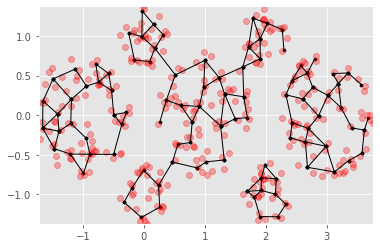

In [224]:
cl1 = distri_circle([+0.0, +1.0], 0.4, N//5)
cl2 = distri_circle([-1.0, +0.0], 0.8, N//2)
cl3 = distri_circle([+0.0, -1.0], 0.4, N//5)
cl4 = distri_circle([+1.0, +0.0], 0.8, N//2)
cl5 = distri_circle([+2.0, +1.0], 0.4, N//5)
cl6 = distri_circle([+3.0, +0.0], 0.8, N//2)
cl7 = distri_circle([+2.0, -1.0], 0.4, N//5)

# shuffle the points to make the statistics stationary
X_train = np.concatenate([cl1, cl2, cl3, cl4, cl5, cl6, cl7], axis=0)
X_train = np.take(X_train, np.random.permutation(X_train.shape[0]), axis=0)

axis_x, axis_y = [], []
for axis_i in X_train:
    axis_x.append(axis_i[0])
    axis_y.append(axis_i[1])
fig = plt.figure()
plt.plot(axis_x, axis_y, 'ro', alpha=0.3)
plt.axis([min(axis_x), max(axis_x), min(axis_y), max(axis_y)])

gng = GrowingNeuralGas(
    n_inputs=2,
    n_start_nodes=2,
    shuffle_data=True,
    verbose=False,
    step=0.1,
    neighbor_step=0.001,
    max_edge_age=50,
    max_nodes=100,
    n_iter_before_neuron_added=100,
    after_split_error_decay_rate=0.5,
    error_decay_rate=0.995,
    min_distance_for_update=0.2
)

def animate(i):
    for line in animate.prev_lines:
        line.remove()
    sampled_data_ids = np.random.choice(len(X_train), int(0.5 * gng.n_iter_before_neuron_added * (1 + i // 100)))
    sampled_data = X_train[sampled_data_ids, :]
    gng.train(sampled_data, epochs=1)
    lines = []
    for node_1, node_2 in gng.graph.edges:
        weights = np.concatenate([node_1.weight, node_2.weight])
        line, = plt.plot(*weights.T, color='black')
        plt.setp(line, linewidth=1, color='black')
        lines.append(line)
        lines.append(plt.scatter(*weights.T, color='black', s=10))
    animate.prev_lines = lines
    return lines

animate.prev_lines = []
HTML(animation.FuncAnimation(fig, animate, tqdm.notebook.tqdm(np.arange(220)), interval=30, blit=True).to_html5_video())

  0%|          | 0/220 [00:00<?, ?it/s]

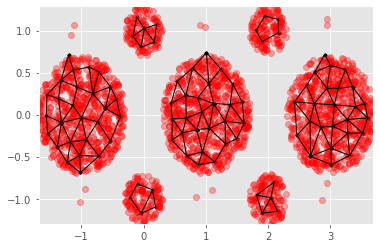

In [241]:
cl1 = distri_circle([+0.0, +1.0], 0.3, N)
cl2 = distri_circle([-1.0, +0.0], 0.7, N*5)
cl3 = distri_circle([+0.0, -1.0], 0.3, N)
cl4 = distri_circle([+1.0, +0.0], 0.7, N*5)
cl5 = distri_circle([+2.0, +1.0], 0.3, N)
cl6 = distri_circle([+3.0, +0.0], 0.7, N*5)
cl7 = distri_circle([+2.0, -1.0], 0.3, N)
no1 = distri_circle([-1.0, +1.0], 0.2, 2)
no2 = distri_circle([+1.0, +1.0], 0.2, 2)
no3 = distri_circle([+3.0, +1.0], 0.2, 2)
no4 = distri_circle([-1.0, -1.0], 0.2, 2)
no5 = distri_circle([+1.0, -1.0], 0.2, 2)
no6 = distri_circle([+3.0, -1.0], 0.2, 2)

# shuffle the points to make the statistics stationary
X_train = np.concatenate([cl1, cl2, cl3, cl4, cl5, cl6, cl7, no1, no2, no3, no4, no5, no6], axis=0)
X_train = np.take(X_train, np.random.permutation(X_train.shape[0]), axis=0)

axis_x, axis_y = [], []
for axis_i in X_train:
    axis_x.append(axis_i[0])
    axis_y.append(axis_i[1])
fig = plt.figure()
plt.plot(axis_x, axis_y, 'ro', alpha=0.3)
plt.axis([min(axis_x), max(axis_x), min(axis_y), max(axis_y)])

gng = GrowingNeuralGas(
    n_inputs=2,
    n_start_nodes=2,
    shuffle_data=True,
    verbose=False,
    step=0.1,
    neighbor_step=0.001,
    max_edge_age=50,
    max_nodes=100,
    n_iter_before_neuron_added=100,
    after_split_error_decay_rate=0.5,
    error_decay_rate=0.995,
    min_distance_for_update=0.2
)

def animate(i):
    for line in animate.prev_lines:
        line.remove()
    sampled_data_ids = np.random.choice(len(X_train), int(0.5 * gng.n_iter_before_neuron_added * (1 + i // 100)))
    sampled_data = X_train[sampled_data_ids, :]
    gng.train(sampled_data, epochs=1)
    lines = []
    for node_1, node_2 in gng.graph.edges:
        weights = np.concatenate([node_1.weight, node_2.weight])
        line, = plt.plot(*weights.T, color='black')
        plt.setp(line, linewidth=1, color='black')
        lines.append(line)
        lines.append(plt.scatter(*weights.T, color='black', s=10))
    animate.prev_lines = lines
    return lines

animate.prev_lines = []
HTML(animation.FuncAnimation(fig, animate, tqdm.notebook.tqdm(np.arange(220)), interval=30, blit=True).to_html5_video())

  0%|          | 0/220 [00:00<?, ?it/s]

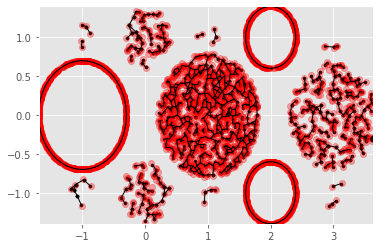

In [335]:
cl1 = distri_circle([+0.0, +1.0], 0.4, N//2)
cl2 = distri_circum([-1.0, +0.0], 0.7, N*4)
cl3 = distri_circle([+0.0, -1.0], 0.4, N//2)
cl4 = distri_circle([+1.0, +0.0], 0.8, N*7)
cl5 = distri_circum([+2.0, +1.0], 0.4, N*2)
cl6 = distri_circle([+3.0, +0.0], 0.7, N*2)
cl7 = distri_circum([+2.0, -1.0], 0.4, N*2)
no1 = distri_circle([-1.0, +1.0], 0.2, 5)
no2 = distri_circle([+1.0, +1.0], 0.2, 5)
no3 = distri_circle([+3.0, +1.0], 0.2, 5)
no4 = distri_circle([-1.0, -1.0], 0.2, 5)
no5 = distri_circle([+1.0, -1.0], 0.2, 5)
no6 = distri_circle([+3.0, -1.0], 0.2, 5)

# shuffle the points to make the statistics stationary
X_train = np.concatenate([cl1, cl2, cl3, cl4, cl5, cl6, cl7, no1, no2, no3, no4, no5, no6], axis=0)
X_train = np.take(X_train, np.random.permutation(X_train.shape[0]), axis=0)

axis_x, axis_y = [], []
for axis_i in X_train:
    axis_x.append(axis_i[0])
    axis_y.append(axis_i[1])
fig = plt.figure()
plt.plot(axis_x, axis_y, 'ro', alpha=0.3)
plt.axis([min(axis_x), max(axis_x), min(axis_y), max(axis_y)])

gng = GrowingNeuralGas(
    n_inputs=2,
    n_start_nodes=2,
    shuffle_data=True,
    verbose=False,
    step=0.1,
    neighbor_step=0.01,
    max_edge_age=100,
    max_nodes=1000,
    n_iter_before_neuron_added=1000,
    after_split_error_decay_rate=50,
    error_decay_rate=0.995,
    min_distance_for_update=0.1
)

def animate(i):
    for line in animate.prev_lines:
        line.remove()
    sampled_data_ids = np.random.choice(len(X_train), int(0.5 * gng.n_iter_before_neuron_added * (1 + i // 100)))
    sampled_data = X_train[sampled_data_ids, :]
    gng.train(sampled_data, epochs=10)
    lines = []
    for node_1, node_2 in gng.graph.edges:
        weights = np.concatenate([node_1.weight, node_2.weight])
        line, = plt.plot(*weights.T, color='black')
        plt.setp(line, linewidth=1, color='black')
        lines.append(line)
        lines.append(plt.scatter(*weights.T, color='black', s=10))
    animate.prev_lines = lines
    return lines

animate.prev_lines = []
HTML(animation.FuncAnimation(fig, animate, tqdm.notebook.tqdm(np.arange(220)), interval=30, blit=True).to_html5_video())

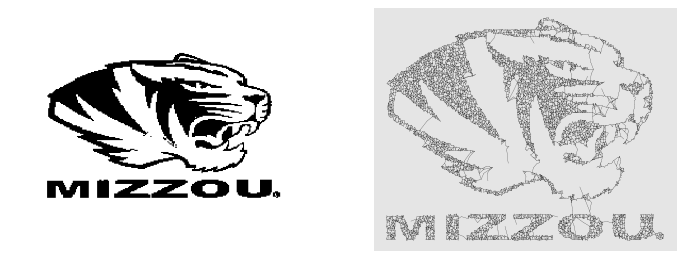

In [429]:
from PIL import Image
from skimage.color import rgb2gray
from skimage.filters import threshold_sauvola
from skimage.transform import resize

def image_to_data(img):
    data = []
    for (x, y), value in np.ndenumerate(img):
        if value == 1:
            data.append([y, -x])
    return data

def draw_image(graph):
    for node_1, node_2 in graph.edges:
        weights = np.concatenate([node_1.weight, node_2.weight])
        line, = plt.plot(*weights.T, color='black')
        plt.setp(line, linewidth=0.2, color='black')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()

image = rgb2gray(np.array(Image.open("mizzou.jpeg")))
binary_image = image > threshold_sauvola(image, window_size=25)
binary_image = resize(np.bitwise_not(binary_image), (230, 280))

gng = GrowingNeuralGas(
    n_inputs=2,
    n_start_nodes=2,
    shuffle_data=True,
    verbose=False,
    step=0.2,
    neighbor_step=0.005,
    max_edge_age=30,
    max_nodes=8000,
    n_iter_before_neuron_added=10,
    after_split_error_decay_rate=0.5,
    error_decay_rate=0.995,
    min_distance_for_update=0.0001
)
gng.train(image_to_data(binary_image), epochs=10)

plt.figure(figsize=(12, 4.5))
plt.subplot(121)
plt.imshow(binary_image, cmap='binary')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
draw_image(gng.graph)

In [408]:
image = rgb2gray(np.array(Image.open("willsmith.jpeg")))
binary_image = image > threshold_sauvola(image, window_size=25)
binary_image = resize(np.bitwise_not(binary_image), (230, 280))

gng = GrowingNeuralGas(
    n_inputs=2,
    n_start_nodes=2,
    shuffle_data=True,
    verbose=False,
    step=0.2,
    neighbor_step=0.005,
    max_edge_age=30,
    max_nodes=20000,
    n_iter_before_neuron_added=10,
    after_split_error_decay_rate=0.5,
    error_decay_rate=0.995,
    min_distance_for_update=0.0001
)
gng.train(image_to_data(binary_image), epochs=20)

plt.figure(figsize=(12, 4.5))
plt.subplot(121)
plt.imshow(binary_image, cmap='binary')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
draw_image(gng.graph)

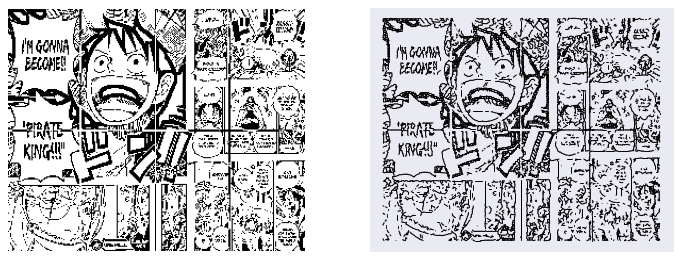

In [635]:
image = rgb2gray(np.array(Image.open("onepiece.jpg")))
binary_image = image > threshold_sauvola(image, window_size=25)
binary_image = resize(np.bitwise_not(binary_image), (230, 280))

gng = GrowingNeuralGas(
    n_inputs=2,
    n_start_nodes=2,
    shuffle_data=True,
    verbose=False,
    step=0.2,
    neighbor_step=0.005,
    max_edge_age=30,
    max_nodes=10000,
    n_iter_before_neuron_added=10,
    after_split_error_decay_rate=0.5,
    error_decay_rate=0.995,
    min_distance_for_update=0.0001
)
gng.train(image_to_data(binary_image), epochs=1000)

plt.figure(figsize=(12, 4.5))
plt.subplot(121)
plt.imshow(binary_image, cmap='binary')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
draw_image(gng.graph)

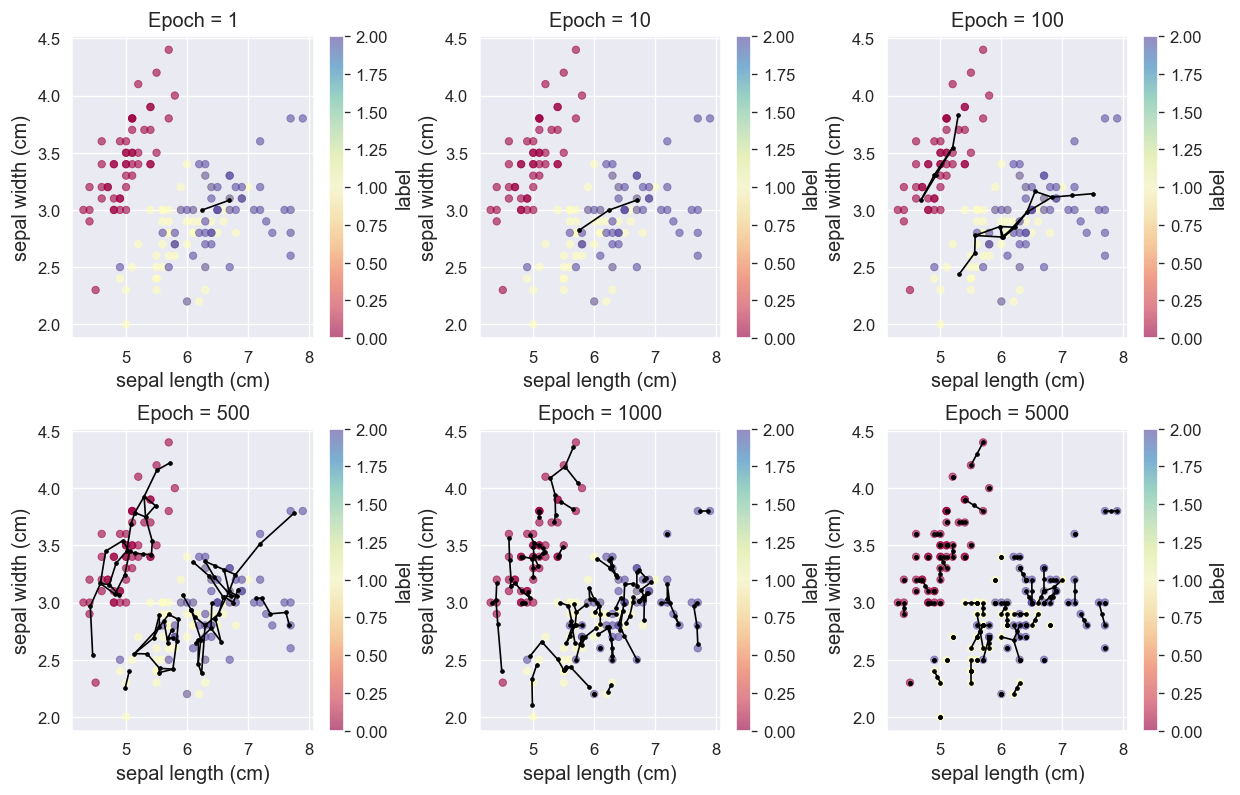

In [631]:
import copy
import pandas as pd
from sklearn import datasets

def get_2d_position(features, all_features):
    return list((all_features.index(feature) for feature in features))

def format_titles(pattern, values, **kwargs):
    return [pattern.format(value=value, **kwargs) for value in values]

def plot_edges(n1, n2, dims:tuple, **kwargs):
    weights = np.concatenate([n1.weight[:, dims], n2.weight[:, dims]])
    return plt.plot(*weights.T, **kwargs)

def plot_nodes(graph, dims, node_kwargs, edge_kwargs):
    for n1, n2 in graph.edges:
        plot_edges(n1, n2, dims, **edge_kwargs)
    weights = np.concatenate([node.weight[:, dims] for node in graph.nodes])
    plt.scatter(*weights.T, **node_kwargs)

def plot_gngs(gngs, titles, dims, bg_spec, grid_spec, title_size, node_kwargs, edge_kwargs):
    for i in range(len(gngs)):
        ax = plt.subplot(grid_spec[0], grid_spec[1], i + 1)
        bg_spec['data'].plot.scatter(bg_spec['x'], bg_spec['y'], c=bg_spec['label'], alpha=0.6, ax=ax, cmap=bg_spec['cmap'])
        plot_nodes(gngs[i].graph, dims, node_kwargs, edge_kwargs)
        plt.title(titles[i], fontdict={'fontsize': title_size})
    plt.subplots_adjust(wspace=0.35)
    plt.subplots_adjust(hspace=0.3)
    plt.show()

iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['label'] = iris.target

parameters = [1, 10, 100, 500, 1000, 5000]
gngs = [copy.deepcopy(GrowingNeuralGas(n_inputs=len(iris.feature_names))) for i in range(len(parameters))]
[gng.train(iris_df.iloc[:, 0:len(iris.feature_names)], epochs=p) for gng, p in zip(gngs, parameters)]

fig = plt.figure(figsize=(12, 12), dpi=120)
plot_gngs(
    gngs,
    format_titles('Epoch = {value}', parameters),
    get_2d_position(['sepal length (cm)', 'sepal width (cm)'], iris.feature_names),
    {'data':iris_df, 'x':'sepal length (cm)', 'y':'sepal width (cm)', 'label':'label', 'cmap':plt.cm.get_cmap('Spectral')},
    (3, 3),
    12,
    {'color': 'k', 'zorder': 1000, 's': 5},
    {'linewidth': 1, 'color': 'k', 'zorder': 500}
)

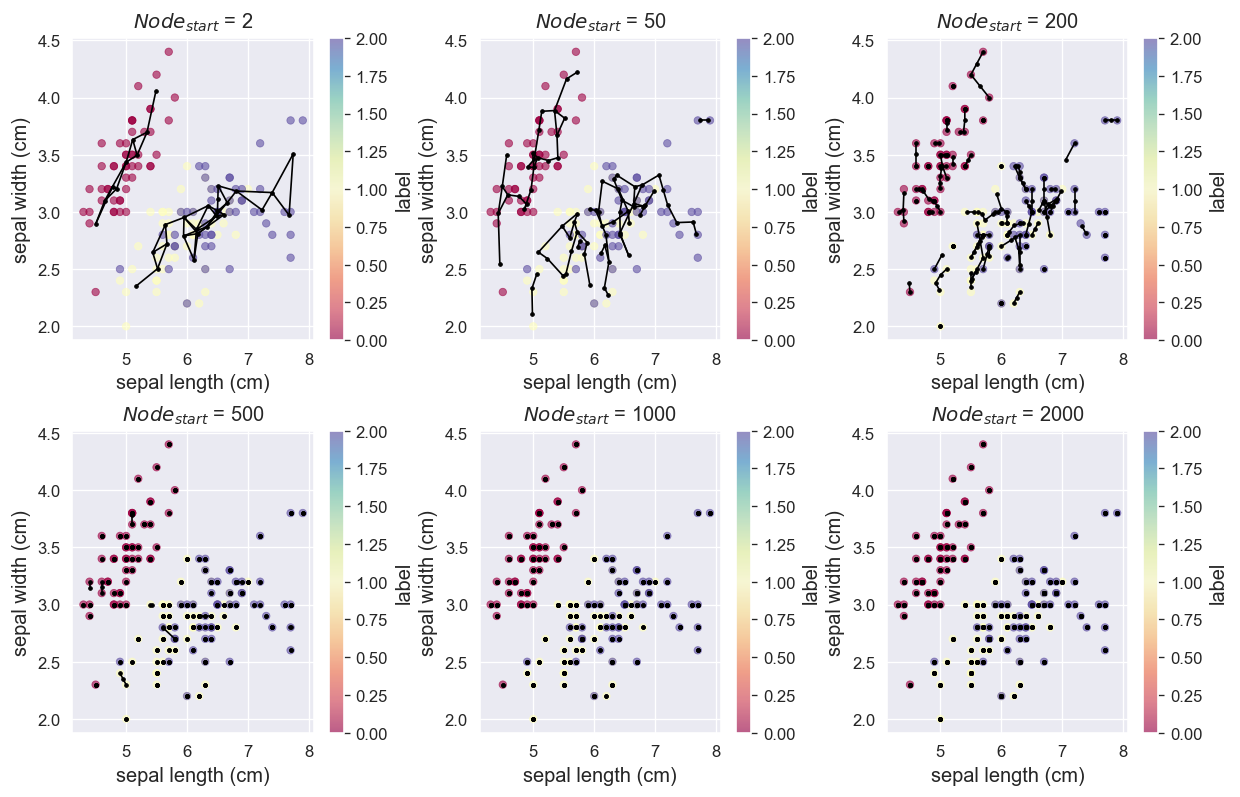

In [627]:
parameters = [2, 50, 200, 500, 1000, 2000]
gngs = [GrowingNeuralGas(n_inputs=len(iris.feature_names), n_start_nodes=p) for p in parameters]
[gng.train(iris_df.iloc[:, 0:len(iris.feature_names)], epochs=200) for gng in gngs]

fig = plt.figure(figsize=(12, 12), dpi=120)
plot_gngs(
    gngs,
    format_titles('$Node_{remark}$ = {value}', parameters, remark='{start}'),
    get_2d_position(['sepal length (cm)', 'sepal width (cm)'], iris.feature_names),
    {'data':iris_df, 'x':'sepal length (cm)', 'y':'sepal width (cm)', 'label':'label', 'cmap':plt.cm.get_cmap('Spectral')},
    (3, 3),
    12,
    {'color': 'k', 'zorder': 1000, 's': 5},
    {'linewidth': 1, 'color': 'k', 'zorder': 500}
)

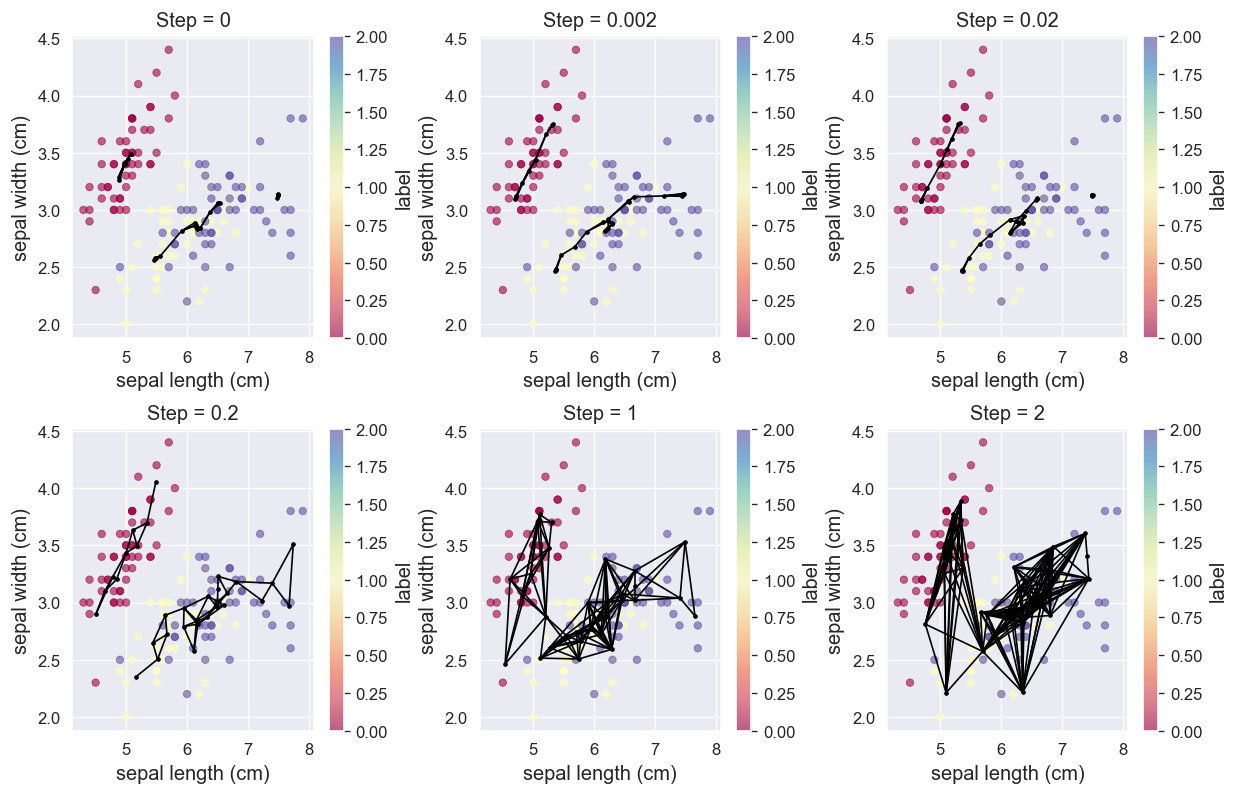

In [609]:
parameters = [0, 0.002, 0.02, 0.2, 1, 2]
gngs = [GrowingNeuralGas(n_inputs=len(iris.feature_names), step=p) for p in parameters]
[gng.train(iris_df.iloc[:, 0:len(iris.feature_names)], epochs=200) for gng in gngs]

fig = plt.figure(figsize=(12, 12), dpi=120)
plot_gngs(
    gngs,
    format_titles('Step = {value}', parameters),
    get_2d_position(['sepal length (cm)', 'sepal width (cm)'], iris.feature_names),
    {'data':iris_df, 'x':'sepal length (cm)', 'y':'sepal width (cm)', 'label':'label', 'cmap':plt.cm.get_cmap('Spectral')},
    (3, 3),
    12,
    {'color': 'k', 'zorder': 1000, 's': 5},
    {'linewidth': 1, 'color': 'k', 'zorder': 500}
)

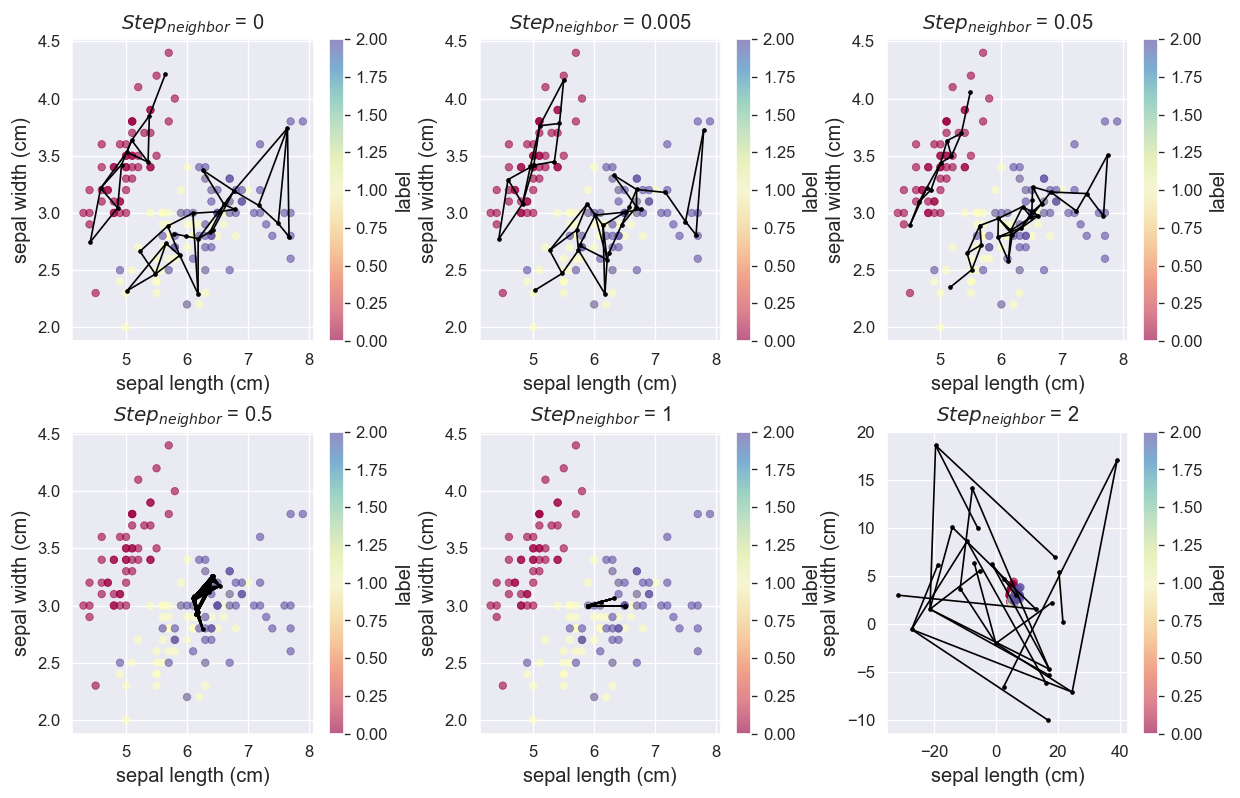

In [614]:
parameters = [0, 0.005, 0.05, 0.5, 1, 2]
gngs = [GrowingNeuralGas(n_inputs=len(iris.feature_names), neighbor_step=p) for p in parameters]
[gng.train(iris_df.iloc[:, 0:len(iris.feature_names)], epochs=200) for gng in gngs]

fig = plt.figure(figsize=(12, 12), dpi=120)
plot_gngs(
    gngs,
    format_titles('$Step_{remark}$ = {value}', parameters, remark='{neighbor}'),
    get_2d_position(['sepal length (cm)', 'sepal width (cm)'], iris.feature_names),
    {'data':iris_df, 'x':'sepal length (cm)', 'y':'sepal width (cm)', 'label':'label', 'cmap':plt.cm.get_cmap('Spectral')},
    (3, 3),
    12,
    {'color': 'k', 'zorder': 1000, 's': 5},
    {'linewidth': 1, 'color': 'k', 'zorder': 500}
)

In [615]:
parameters = [10, 50, 100, 500, 1000, 5000]
gngs = [GrowingNeuralGas(n_inputs=len(iris.feature_names), max_edge_age=p) for p in parameters]
[gng.train(iris_df.iloc[:, 0:len(iris.feature_names)], epochs=200) for gng in gngs]

fig = plt.figure(figsize=(12, 12), dpi=120)
plot_gngs(
    gngs,
    format_titles('$Age_{remark}$ = {value}', parameters, remark='{max}'),
    get_2d_position(['sepal length (cm)', 'sepal width (cm)'], iris.feature_names),
    {'data':iris_df, 'x':'sepal length (cm)', 'y':'sepal width (cm)', 'label':'label', 'cmap':plt.cm.get_cmap('Spectral')},
    (3, 3),
    12,
    {'color': 'k', 'zorder': 1000, 's': 5},
    {'linewidth': 1, 'color': 'k', 'zorder': 500}
)

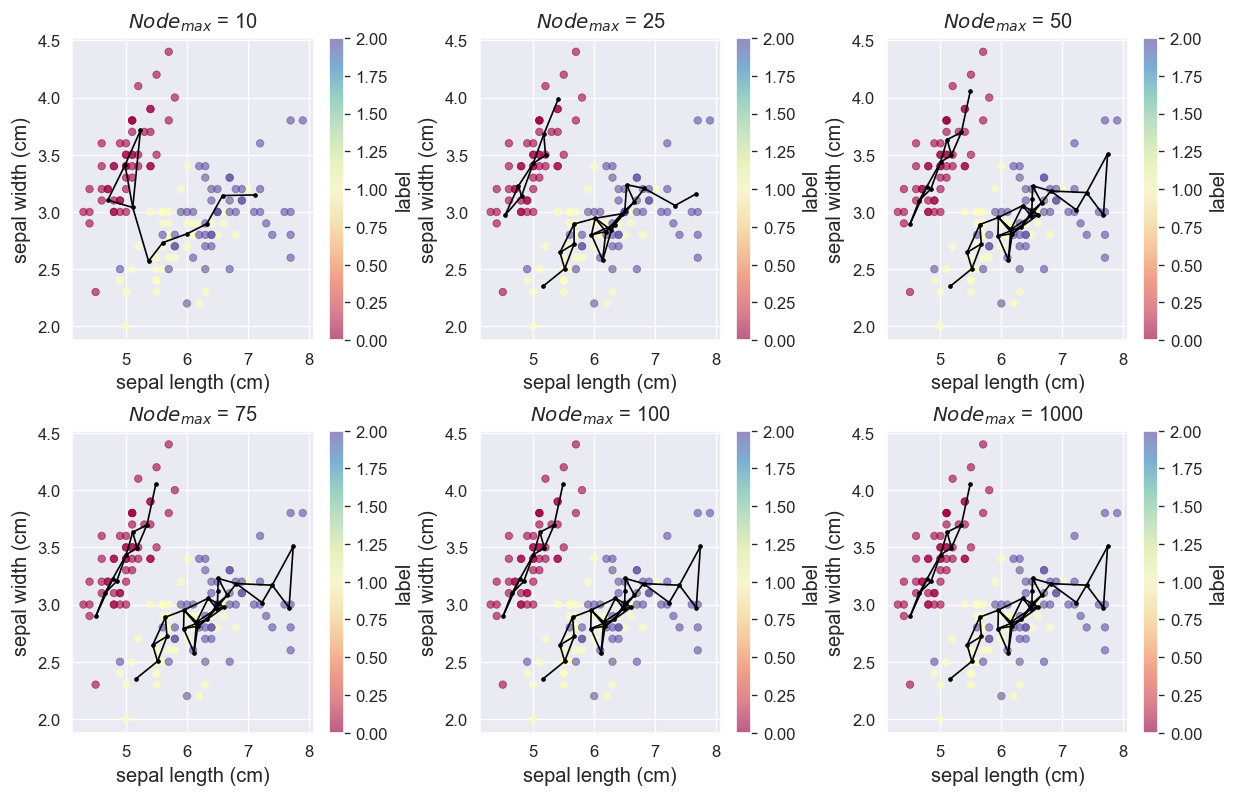

In [616]:
parameters = [10, 25, 50, 75, 100, 1000]
gngs = [GrowingNeuralGas(n_inputs=len(iris.feature_names), max_nodes=p) for p in parameters]
[gng.train(iris_df.iloc[:, 0:len(iris.feature_names)], epochs=200) for gng in gngs]

fig = plt.figure(figsize=(12, 12), dpi=120)
plot_gngs(
    gngs,
    format_titles('$Node_{remark}$ = {value}', parameters, remark='{max}'),
    get_2d_position(['sepal length (cm)', 'sepal width (cm)'], iris.feature_names),
    {'data':iris_df, 'x':'sepal length (cm)', 'y':'sepal width (cm)', 'label':'label', 'cmap':plt.cm.get_cmap('Spectral')},
    (3, 3),
    12,
    {'color': 'k', 'zorder': 1000, 's': 5},
    {'linewidth': 1, 'color': 'k', 'zorder': 500}
)

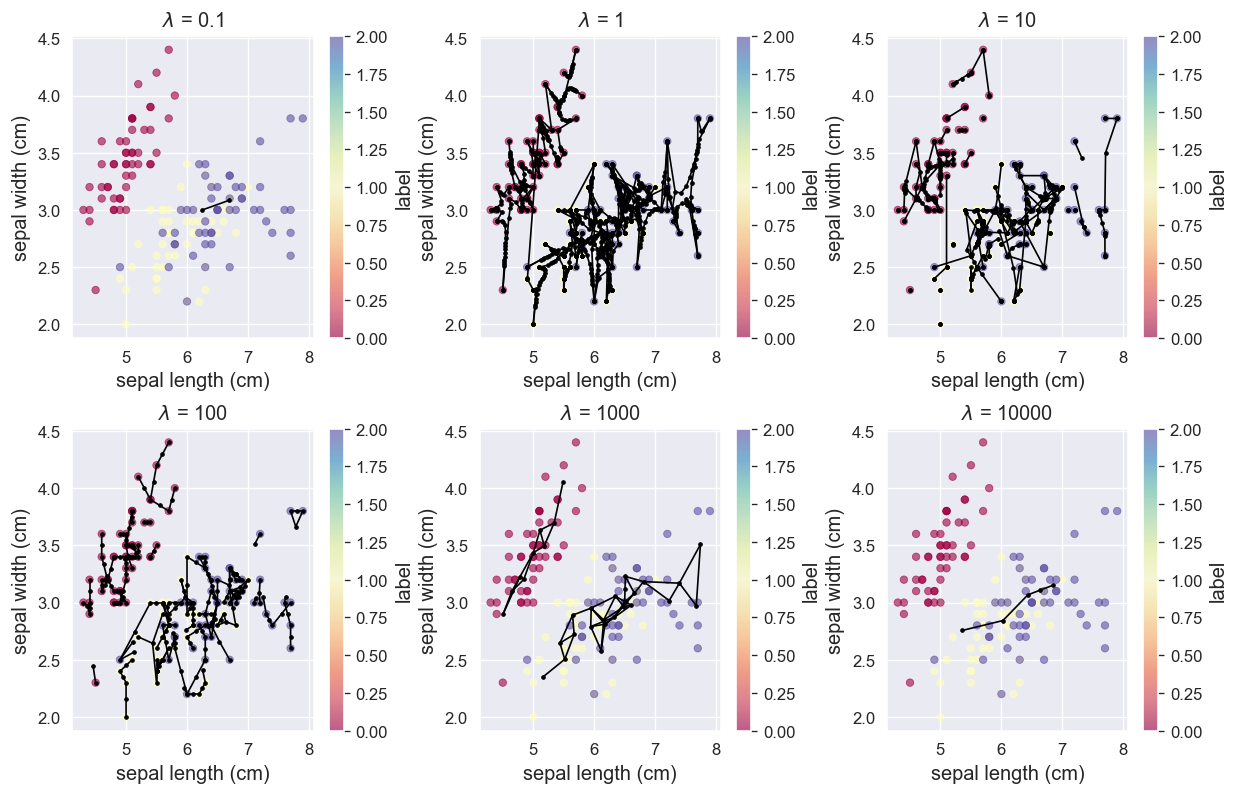

In [591]:
parameters = [0.1, 1, 10, 100, 1000, 10000]
gngs = [GrowingNeuralGas(n_inputs=len(iris.feature_names), n_iter_before_neuron_added=p) for p in parameters]
[gng.train(iris_df.iloc[:, 0:len(iris.feature_names)], epochs=200) for gng in gngs]

fig = plt.figure(figsize=(12, 12), dpi=120)
plot_gngs(
    gngs,
    format_titles('$\lambda$ = {value}', parameters),
    get_2d_position(['sepal length (cm)', 'sepal width (cm)'], iris.feature_names),
    {'data':iris_df, 'x':'sepal length (cm)', 'y':'sepal width (cm)', 'label':'label', 'cmap':plt.cm.get_cmap('Spectral')},
    (3, 3),
    12,
    {'color': 'k', 'zorder': 1000, 's': 5},
    {'linewidth': 1, 'color': 'k', 'zorder': 500}
)

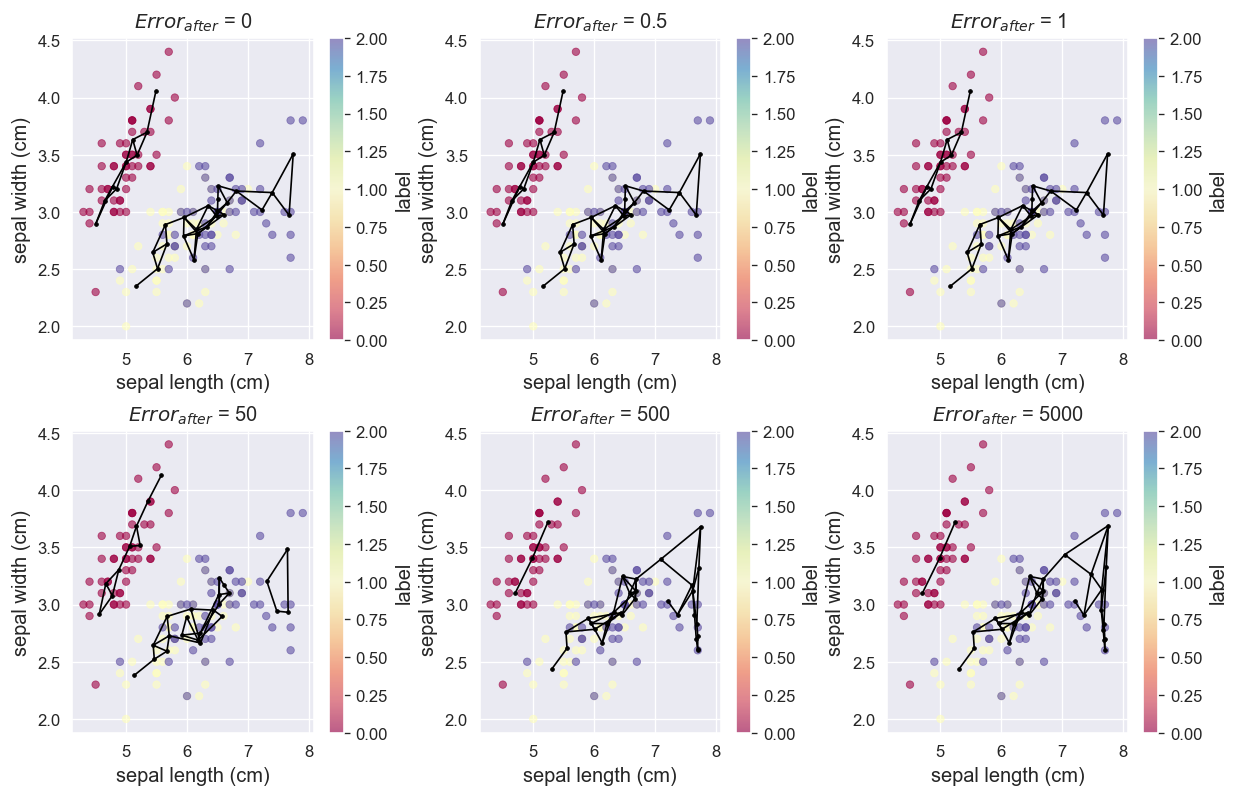

In [617]:
parameters = [0, 0.5, 1, 50, 500, 5000]
gngs = [GrowingNeuralGas(n_inputs=len(iris.feature_names), after_split_error_decay_rate=p) for p in parameters]
[gng.train(iris_df.iloc[:, 0:len(iris.feature_names)], epochs=200) for gng in gngs]

fig = plt.figure(figsize=(12, 12), dpi=120)
plot_gngs(
    gngs,
    format_titles('$Error_{remark}$ = {value}', parameters, remark='{after}'),
    get_2d_position(['sepal length (cm)', 'sepal width (cm)'], iris.feature_names),
    {'data':iris_df, 'x':'sepal length (cm)', 'y':'sepal width (cm)', 'label':'label', 'cmap':plt.cm.get_cmap('Spectral')},
    (3, 3),
    12,
    {'color': 'k', 'zorder': 1000, 's': 5},
    {'linewidth': 1, 'color': 'k', 'zorder': 500}
)

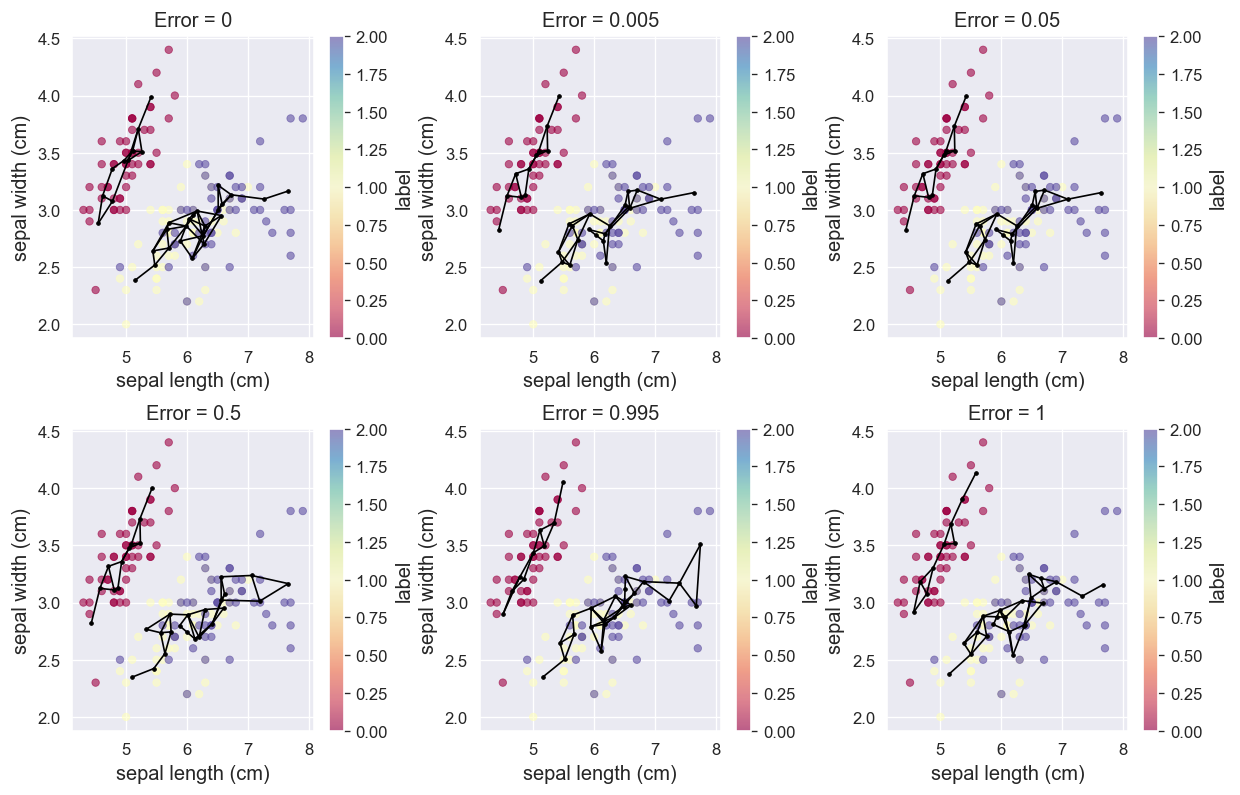

In [618]:
parameters = [0, 0.005, 0.05, 0.5, 0.995, 1]
gngs = [GrowingNeuralGas(n_inputs=len(iris.feature_names), error_decay_rate=p) for p in parameters]
[gng.train(iris_df.iloc[:, 0:len(iris.feature_names)], epochs=200) for gng in gngs]

fig = plt.figure(figsize=(12, 12), dpi=120)
plot_gngs(
    gngs,
    format_titles('Error = {value}', parameters),
    get_2d_position(['sepal length (cm)', 'sepal width (cm)'], iris.feature_names),
    {'data':iris_df, 'x':'sepal length (cm)', 'y':'sepal width (cm)', 'label':'label', 'cmap':plt.cm.get_cmap('Spectral')},
    (3, 3),
    12,
    {'color': 'k', 'zorder': 1000, 's': 5},
    {'linewidth': 1, 'color': 'k', 'zorder': 500}
)

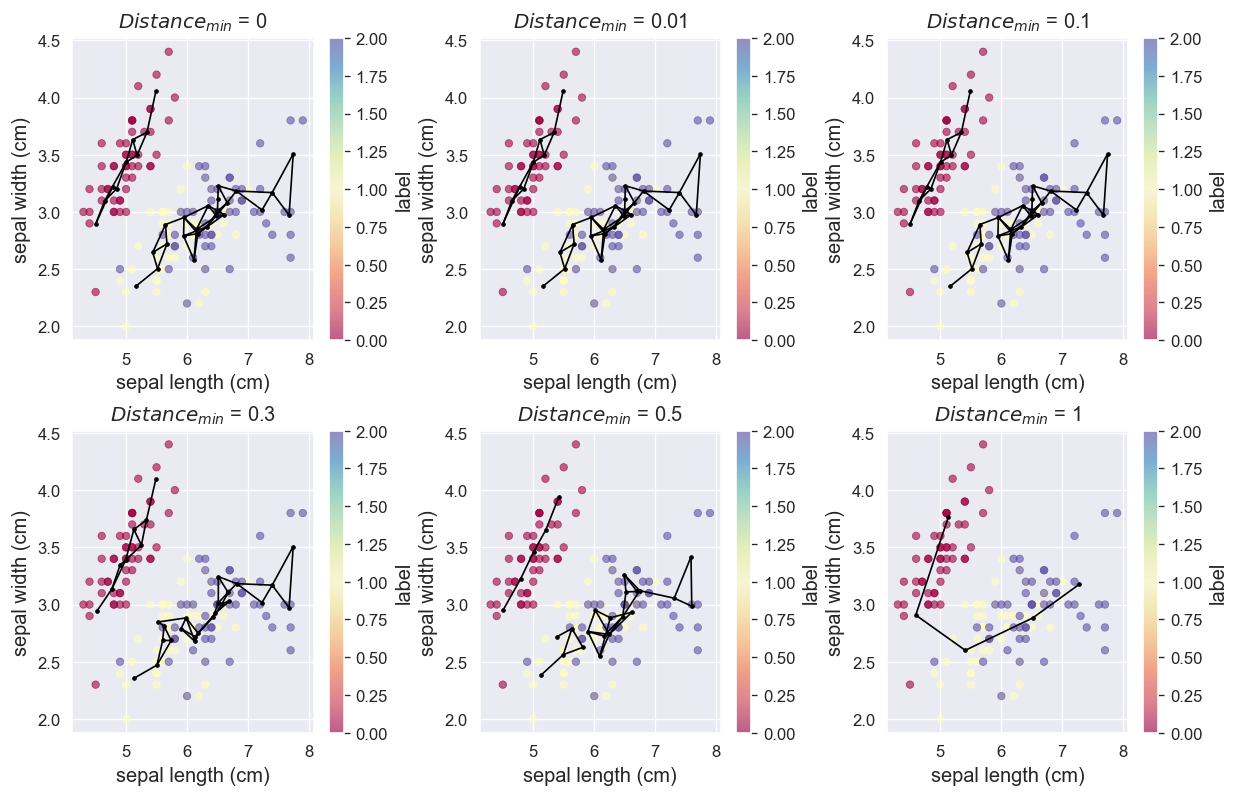

In [624]:
parameters = [0, 0.01, 0.1, 0.3, 0.5, 1]
gngs = [GrowingNeuralGas(n_inputs=len(iris.feature_names), min_distance_for_update=p) for p in parameters]
[gng.train(iris_df.iloc[:, 0:len(iris.feature_names)], epochs=200) for gng in gngs]

fig = plt.figure(figsize=(12, 12), dpi=120)
plot_gngs(
    gngs,
    format_titles('$Distance_{remark}$ = {value}', parameters, remark='{min}'),
    get_2d_position(['sepal length (cm)', 'sepal width (cm)'], iris.feature_names),
    {'data':iris_df, 'x':'sepal length (cm)', 'y':'sepal width (cm)', 'label':'label', 'cmap':plt.cm.get_cmap('Spectral')},
    (3, 3),
    12,
    {'color': 'k', 'zorder': 1000, 's': 5},
    {'linewidth': 1, 'color': 'k', 'zorder': 500}
)

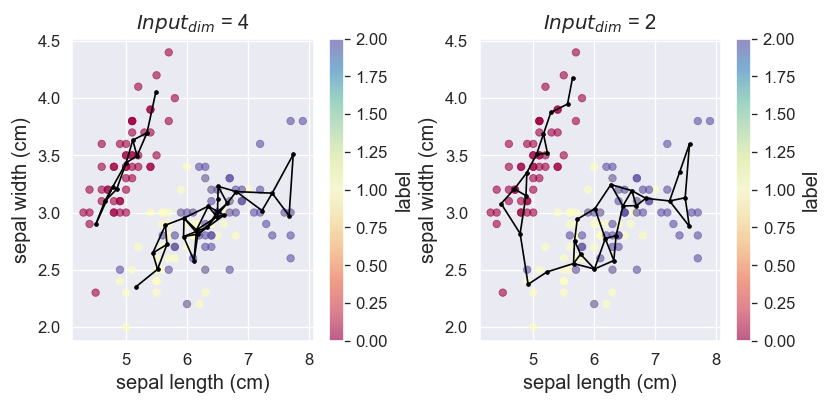

In [630]:
gng = GrowingNeuralGas(n_inputs=len(iris.feature_names))
gng.train(iris_df.iloc[:, 0:len(iris.feature_names)], epochs=200)

iris_df2 = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df2 = iris_df2.drop(columns=['petal length (cm)', 'petal width (cm)'])
iris_df2['label'] = iris.target

gng2 = GrowingNeuralGas(n_inputs=2)
gng2.train(iris_df2.iloc[:, 0:2], epochs=200)

fig = plt.figure(figsize=(12, 12), dpi=120)
plot_gngs(
    [gng, gng2],
    format_titles('$Input_{remark}$ = {value}', [len(iris.feature_names), 2], remark='{dim}'),
    get_2d_position(['sepal length (cm)', 'sepal width (cm)'], iris.feature_names),
    {'data':iris_df, 'x':'sepal length (cm)', 'y':'sepal width (cm)', 'label':'label', 'cmap':plt.cm.get_cmap('Spectral')},
    (3, 3),
    12,
    {'color': 'k', 'zorder': 1000, 's': 5},
    {'linewidth': 1, 'color': 'k', 'zorder': 500}
)